In [1]:
#notebooks/eda.ipynb

In [2]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Set global plotting style
sns.set(style = "whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [4]:
# Load Cleaned and Preprocessed Data
data_path = "../data/processed/clean_consumer_complaints.csv"
df = pd.read_csv(data_path, low_memory = False)
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (66806, 15)


,product,issue,company,state,timely_response,text_cleaned,consumer_disputed_binary,timely_response_binary,text_length,product_dispute_rate,company_dispute_rate,sentiment,sentiment_encoded,sentiment_timely_interaction,company_timely_interaction
0,Debt collection,Cont'd attempts collect debt not owed,"Diversified Consultants, Inc.",NY,Yes,xxxx has claimed i owe them for xxxx years des...,0,1,52,0.222881,0.181818,extreme_negative,2,2,0.181818
1,Consumer Loan,Managing the loan or lease,M&T Bank Corporation,VA,Yes,due to inconsistencies in the amount owed that...,0,1,238,0.247961,0.223464,extreme_negative,2,2,0.223464
2,Mortgage,"Loan modification,collection,foreclosure",Wells Fargo & Company,CA,Yes,in xxxxxxxx my wages that i earned at my job d...,1,1,655,0.267176,0.279024,extreme_negative,2,2,0.279024
3,Mortgage,"Loan servicing, payments, escrow account",JPMorgan Chase & Co.,CA,Yes,i have an open and current mortgage with chase...,1,1,74,0.267176,0.281903,neutral,0,0,0.281903
4,Mortgage,Credit decision / Underwriting,Rushmore Loan Management Services LLC,CA,Yes,xxxx was submitted xxxxxxxx at the time i subm...,1,1,259,0.267176,0.365585,extreme_negative,2,2,0.365585


#### Missing Values and Data quality

In [5]:
# Calculate missing percentages
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct

product                         0.0
issue                           0.0
company                         0.0
state                           0.0
timely_response                 0.0
text_cleaned                    0.0
consumer_disputed_binary        0.0
timely_response_binary          0.0
text_length                     0.0
product_dispute_rate            0.0
company_dispute_rate            0.0
sentiment                       0.0
sentiment_encoded               0.0
sentiment_timely_interaction    0.0
company_timely_interaction      0.0
dtype: float64

# Initial Review
* Dataset has 66806 complaints and 15 columns.
* No major missing values (cleaned previously during preprocessing)
* Data includes structured fields (products, issue, company, state, etc.) and derived fields(text_cleaned, sentiment, text_length)
* Sentiment labels(sentiment) and weak labeling(sentiment_encoded) are present - ready for modeling.
* Numeric transformation(text_length, product_dispute_rate, etc) are available.

# Sentiment Distribution

### Complaint Length
#### H2: Longer complaints more emotional?

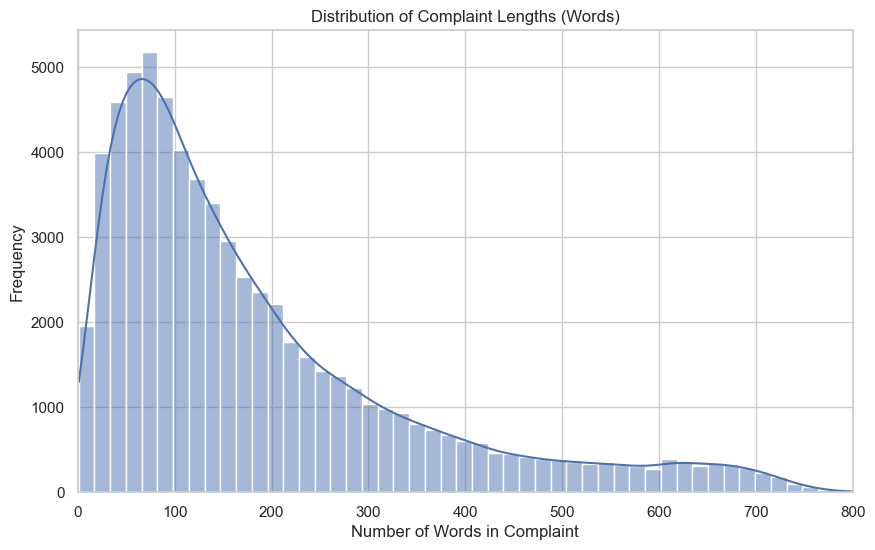

count    66806.000000
mean       185.058812
std        161.336542
min          1.000000
25%         69.000000
50%        132.000000
75%        247.000000
max        813.000000
Name: text_length, dtype: float64

In [6]:
plt.figure(figsize = (10,6))
sns.histplot(df["text_length"], bins=50, kde = True)
plt.title("Distribution of Complaint Lengths (Words)")
plt.xlabel("Number of Words in Complaint")
plt.ylabel("Frequency")
plt.xlim(0,800)
plt.show()

# Length statistics
df['text_length'].describe()

#### Insights
* Highly right-skewed distribution
* Longer complaints tend to be more emotionally driven -> potential sentiment signal
* Majority complaints are short to medium (50-250 words).
* Mean = ~200 words and max = ~ 800 words
   #### Supports Hypothesis H2:
  * Longer complaints likely indicate more severe, emotional experiences(potentially extreme negative.)
#### Strategy
* Cap length at 500 to reduce long-tail impact in modeling 
* Supports H2: Negative or detailed narrative correalte with disputes

### Sentiment distribution
#### (H1, General Health Check)

/var/folders/2r/y7hrs20n4cn4zxfmg53ncysh0000gn/T/ipykernel_1356/3711111862.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


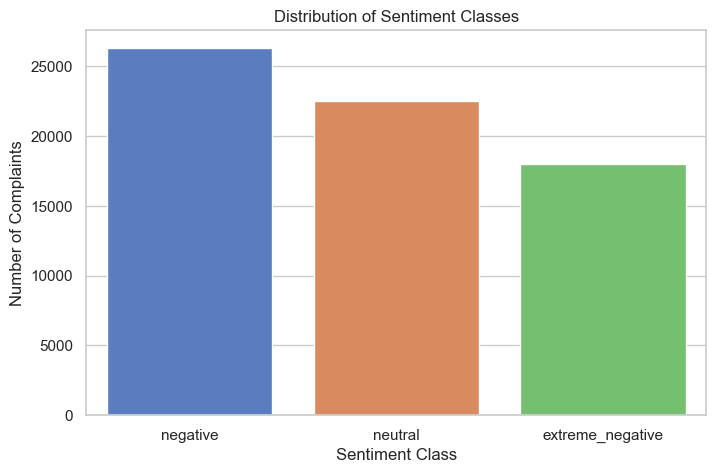

count        66806
unique           3
top       negative
freq         26286
Name: sentiment, dtype: object

In [7]:
# Sentiment distribution plot
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")
plt.title("Distribution of Sentiment Classes")
plt.ylabel("Number of Complaints")
plt.xlabel("Sentiment Class")
plt.show()

# Show counts
sentiment_counts

# sentiment_statistics
df['sentiment'].describe()

#### Insights
* negative complaints dominate -> Logical, expected for CFPB consumer compliants
* We have a decent class imbalance (not very extreme), but we should:
  * Use stratified splits during modeling,
  * Potentially use class weights or oversampling during training.

Supports H2 since extreme negative could be because of longer text

### Product vs Sentiment Analysis

In [8]:
# Group data by Product and Sentiment
product_sentiment = df.groupby(["product", "sentiment"]).size().unstack(fill_value=0)
product_sentiment

sentiment,extreme_negative,negative,neutral
product,,,
Bank account or service,1633,2622,1456
Consumer Loan,783,1508,1387
Credit card,2009,3657,2263
Credit reporting,3448,5129,3949
Debt collection,3881,6036,7635
Money transfers,154,294,218
Mortgage,5313,5565,4041
Other financial service,30,42,38
Payday loan,151,252,323


In [9]:
#Normalize to % inside each product
product_sentiment_pct = product_sentiment.div(product_sentiment.sum(axis=1), axis=0) * 100
product_sentiment_pct

sentiment,extreme_negative,negative,neutral
product,,,
Bank account or service,28.593942,45.911399,25.494659
Consumer Loan,21.288744,41.000544,37.710712
Credit card,25.337369,46.121831,28.540800
Credit reporting,27.526744,40.946831,31.526425
Debt collection,22.111440,34.389243,43.499316
Money transfers,23.123123,44.144144,32.732733
Mortgage,35.612306,37.301428,27.086266
Other financial service,27.272727,38.181818,34.545455
Payday loan,20.798898,34.710744,44.490358


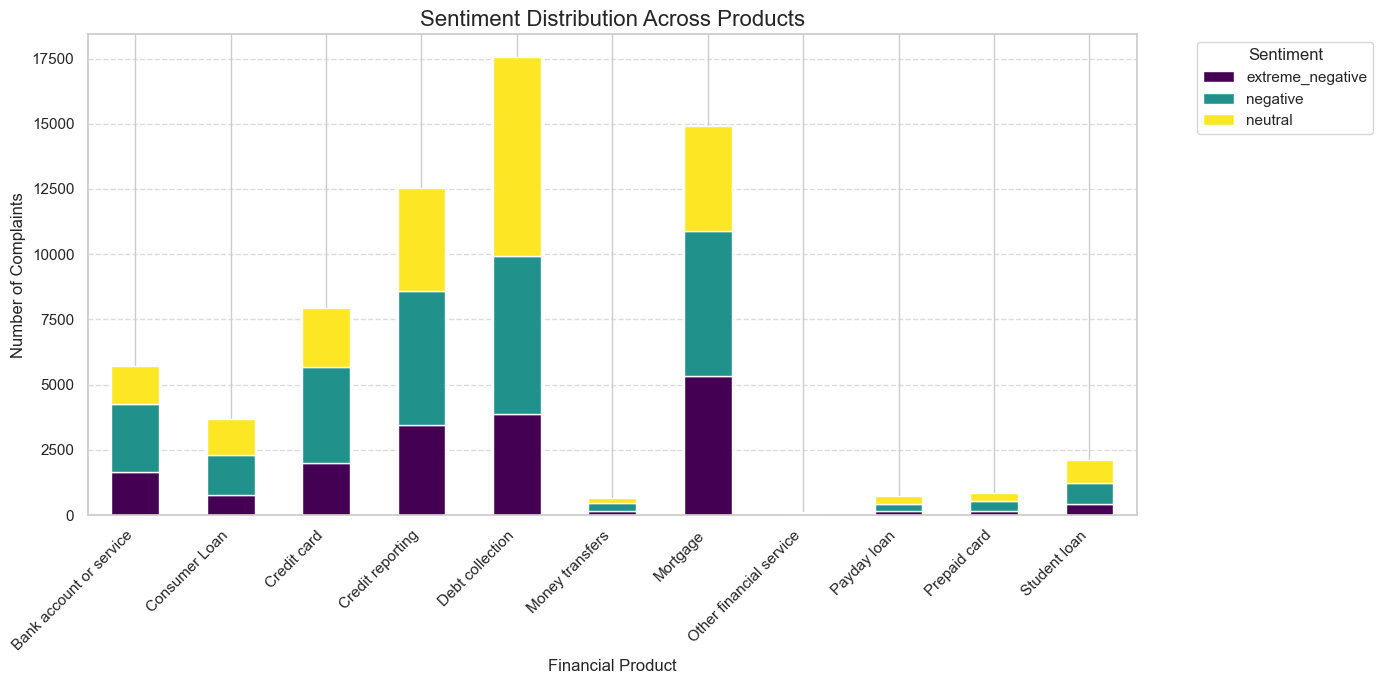

sentiment,extreme_negative,negative,neutral
product,,,
Bank account or service,28.6,45.9,25.5
Consumer Loan,21.3,41.0,37.7
Credit card,25.3,46.1,28.5
Credit reporting,27.5,40.9,31.5
Debt collection,22.1,34.4,43.5
Money transfers,23.1,44.1,32.7
Mortgage,35.6,37.3,27.1
Other financial service,27.3,38.2,34.5
Payday loan,20.8,34.7,44.5


In [10]:
# Plot the stacked bar chart
product_sentiment.plot(kind="bar", stacked=True, figsize=(14,7), colormap="viridis")
plt.title("Sentiment Distribution Across Products", fontsize=16)
plt.ylabel("Number of Complaints")
plt.xlabel("Financial Product")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#Display percentages for deeper insights
display(product_sentiment_pct.round(1))

### Insight: Product vs Sentiment
* Credit Reporting, Debt collection, and Mortgage products show the highest proportion of extreme negative sentiment.
* Credit Reporting has almost 15-20% extreme negative sentiment cases -  very high emotional escalation
* Mortgage and Debt collectiion also show above-average anger.
* Other loans(Student loan, Vehicle Loan) tend to be more neutral in complaints.
### H1 Confirmed
* Certain financial products(like Credit Reporting, Debt Collection) are more associated with extreme negative sentiment.

### Strategy
* Later modeling or dashboarding should segment carefully by product because product type is a strong sentiment driver.
* Could even create Product Risk Scores based on extreme negative rates!

### Company vs Sentiment Analysis

# Focus on top 20 companies by number of complaints

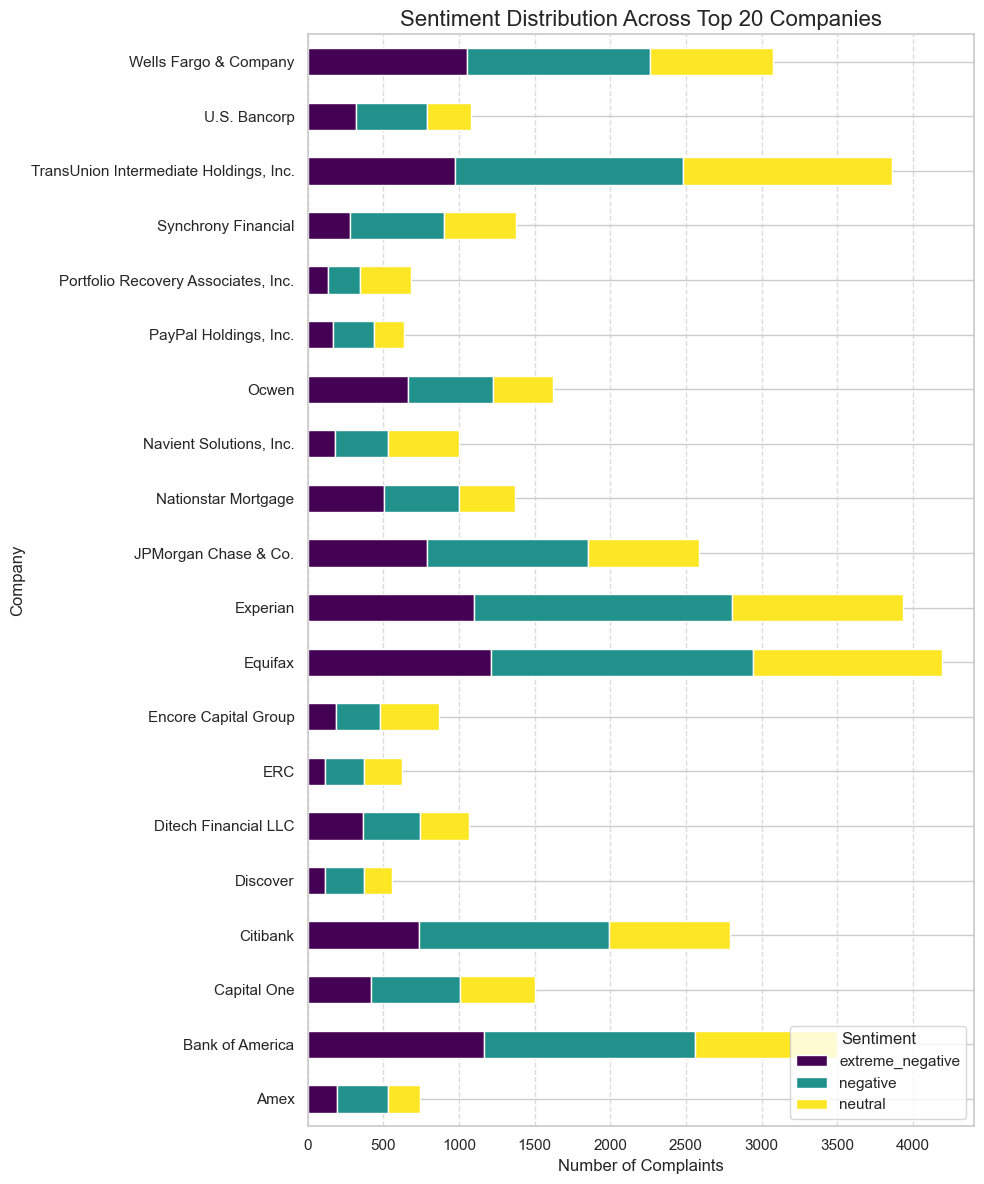

sentiment,extreme_negative,negative,neutral
company,,,
Amex,26.1,45.3,28.6
Bank of America,33.3,39.9,26.8
Capital One,27.7,39.3,33.0
Citibank,26.3,45.2,28.5
Discover,20.9,45.5,33.6
Ditech Financial LLC,33.9,35.9,30.2
ERC,18.3,41.3,40.4
Encore Capital Group,22.0,33.5,44.5
Equifax,28.9,41.2,29.9


In [11]:
# Focus on top 20 companies by number of complaints
top_20_companies = df['company'].value_counts().nlargest(20).index

# Filter dataset
df_top_companies = df[df['company'].isin(top_20_companies)]

# Group by Company and Sentiment
company_sentiment = df_top_companies.groupby(["company", "sentiment"]).size().unstack(fill_value=0)

# Normalize within companies
company_sentiment_pct = company_sentiment.div(company_sentiment.sum(axis=1), axis=0) * 100

# Plot
company_sentiment.plot(kind="barh", stacked=True, figsize=(10,12), colormap="viridis")
plt.title("Sentiment Distribution Across Top 20 Companies", fontsize=16)
plt.xlabel("Number of Complaints")
plt.ylabel("Company")
plt.legend(title="Sentiment", loc='lower right')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Display percentages
display(company_sentiment_pct.round(1))


### Insight: Company vs Sentiment
* Companies like <b>Equifax, Experian, and TransUnion (Credit Reporting Agencies)</b> have the highest extreme negative rates.
* Some banks like Well Fargo, Bank of America also have noticeable negative sentiment but relatively more neutral complaints.
* Mortgage servicers also show higher anger ratios.

### Hypothesis H3 confirmed:
Specific companies show consistent patterns of high-negative emotional feedback.

### Strategy Suggestion:
* Could create Company Sentiment Profiles later in dashboards(Tableau)

### Timely Response vs Sentiment Analysis

In [12]:
#Crosstab between Timely Response and Sentiment
timely_sentiment = pd.crosstab(df["timely_response_binary"],df["sentiment"], normalize = "index") * 100
timely_sentiment

sentiment,extreme_negative,negative,neutral
timely_response_binary,,,
0,24.308118,36.992620,38.699262
1,26.982580,39.425725,33.591695


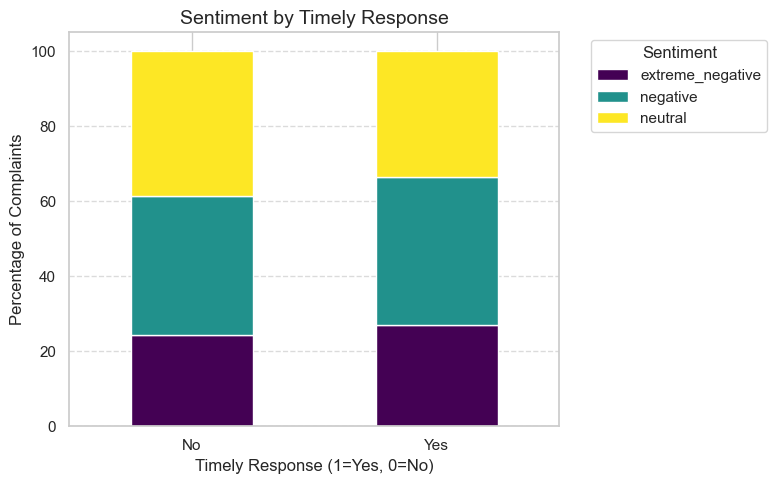

sentiment,extreme_negative,negative,neutral
timely_response_binary,,,
0,24.3,37.0,38.7
1,27.0,39.4,33.6


In [13]:
#Plot
timely_sentiment.plot(kind="bar", stacked=True, figsize=(8,5), colormap="viridis")
plt.title("Sentiment by Timely Response", fontsize=14)
plt.xlabel("Timely Response (1=Yes, 0=No)")
plt.ylabel("Percentage of Complaints")
plt.xticks([0,1], ["No","Yes"], rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Sentiment", bbox_to_anchor = (1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Display
display(timely_sentiment.round(1))

### Insight: Timely Response vs Sentiment
* Whether a complaint was responsed to timely or not does not drastically shift emotional sentiment!
* Both timely and untimely response have similar ratios of neutral, negative, and extreme negative.

### Hypothesis H5 rejected:
Timely reponse (Yes/No) from company has minor or no direct effect on consumer emotional sentiment.
* In modeling, timely response may not need to be a heavy-weight feature.
* Emotional escalation seems more tied to product, company, and complaint text itself.

## Keyword Analysis in Complaints

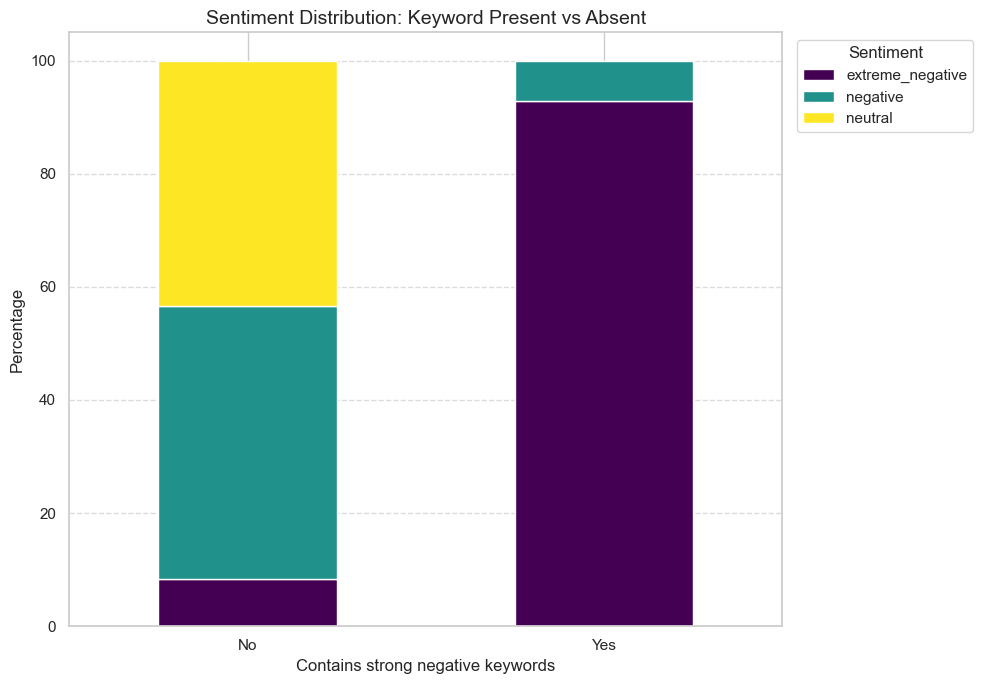

sentiment,extreme_negative,negative,neutral
keyword_flag,,,
False,8.26,48.44,43.31
True,92.80,7.20,0.00


In [14]:
# Check presence of strong negative keywords
important_keywords = ["fraud", "harassment", "scam", "lawsuit", "stolen", "unauthorized", "foreclosure", "repossession"]

# Function to detect keyword presence
def keyword_presence(text):
    return any(keyword in text.lower() for keyword in important_keywords)

df["keyword_flag"] = df["text_cleaned"].apply(keyword_presence)

#Keyword vs Sentiment Crosstab
keyword_sentiment = pd.crosstab(df["keyword_flag"],df["sentiment"], normalize="index")*100
keyword_sentiment

#Plot
keyword_sentiment.plot(kind="bar", stacked=True, figsize=(10,7), colormap="viridis")
plt.title("Sentiment Distribution: Keyword Present vs Absent", fontsize=14)
plt.xlabel("Contains strong negative keywords")
plt.ylabel("Percentage")
plt.xticks([0,1], ["No","Yes"], rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Sentiment", bbox_to_anchor=(1.01,1))
plt.tight_layout()
plt.show()

#Display
display(keyword_sentiment.round(2))

# Insight: Keyword Presence vs Sentiment
* Complaints containing harsh keywords have much higher extreme negative rates(~93%)!
* Complaints with out those keywords tend to be more netral (only ~ 45%) though
# Hypothesis H4 Confirmed:
Complaints with specific keyword are more likely to be extreme negative.

# Strategy
* Keyword flag can be used later as additional feature in modeling!
* Complaints with such words should be weighted as more emotionally charged

## Correlation Analysis

In [15]:
# Only select numeric fields
corr_cols = [
    "consumer_disputed_binary", "timely_response_binary", "text_length",
    "product_dispute_rate", "company_dispute_rate", "sentiment_encoded",
    "sentiment_timely_interaction", "company_timely_interaction"
]
corr_matrix = df[corr_cols].corr()
corr_matrix

,consumer_disputed_binary,timely_response_binary,text_length,product_dispute_rate,company_dispute_rate,sentiment_encoded,sentiment_timely_interaction,company_timely_interaction
consumer_disputed_binary,1.000000,0.034463,0.093156,0.059400,0.196121,0.070995,0.076946,0.178627
timely_response_binary,0.034463,1.000000,0.017659,0.043927,0.046044,0.017775,0.212015,0.535297
text_length,0.093156,0.017659,1.000000,0.229544,0.090367,0.351318,0.340909,0.084391
product_dispute_rate,0.059400,0.043927,0.229544,1.000000,0.316307,0.091730,0.097465,0.290457
company_dispute_rate,0.196121,0.046044,0.090367,0.316307,1.000000,0.074491,0.082272,0.857043
sentiment_encoded,0.070995,0.017775,0.351318,0.091730,0.074491,1.000000,0.964688,0.072047
sentiment_timely_interaction,0.076946,0.212015,0.340909,0.097465,0.082272,0.964688,1.000000,0.175641
company_timely_interaction,0.178627,0.535297,0.084391,0.290457,0.857043,0.072047,0.175641,1.000000


# Insight: Correlation Analysis
* company_dispute_rate vs company_timely_interaction -> 0.857
  * Very strong correlation - companies with more dipsutes also fail more often at responding on time.
  * Indicates systematic issues in company behavior, not just isolated cases.
  * Hypothesis H3 (Specific companies show consistent patterns of high-negative emotional feedback.) supported

# Implementing Insights and Strategies

In [16]:
#Company Grouping
df["company_grouped"] = df["company"].apply(lambda x:x if x in top_20_companies else "Other_Company")
df["company_grouped"]
df = df.drop("company", axis = 1)

In [17]:
# Issue Grouping
# Focus on top 20 issue by number of complaints
top_20_issues = df['issue'].value_counts().nlargest(20).index

df["issue_grouped"] = df["issue"].apply(lambda x : x if x in top_20_issues else "Other_Issue")
df = df.drop("issue", axis=1)

In [18]:
df = df.drop(columns=["sentiment_timely_interaction", "company_timely_interaction"], axis=1)
df

,product,state,timely_response,text_cleaned,consumer_disputed_binary,timely_response_binary,text_length,product_dispute_rate,company_dispute_rate,sentiment,sentiment_encoded,keyword_flag,company_grouped,issue_grouped
0,Debt collection,NY,Yes,xxxx has claimed i owe them for xxxx years des...,0,1,52,0.222881,0.181818,extreme_negative,2,True,Other_Company,Cont'd attempts collect debt not owed
1,Consumer Loan,VA,Yes,due to inconsistencies in the amount owed that...,0,1,238,0.247961,0.223464,extreme_negative,2,True,Other_Company,Managing the loan or lease
2,Mortgage,CA,Yes,in xxxxxxxx my wages that i earned at my job d...,1,1,655,0.267176,0.279024,extreme_negative,2,True,Wells Fargo & Company,"Loan modification,collection,foreclosure"
3,Mortgage,CA,Yes,i have an open and current mortgage with chase...,1,1,74,0.267176,0.281903,neutral,0,False,JPMorgan Chase & Co.,"Loan servicing, payments, escrow account"
4,Mortgage,CA,Yes,xxxx was submitted xxxxxxxx at the time i subm...,1,1,259,0.267176,0.365585,extreme_negative,2,False,Other_Company,Other_Issue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66801,Credit reporting,WA,Yes,xxxx xxxx is reporting incorrectly payments ha...,0,1,20,0.214354,0.191302,neutral,0,False,"TransUnion Intermediate Holdings, Inc.",Incorrect information on credit report
66802,Credit reporting,WA,Yes,reflecting incorrect payment status have been ...,0,1,8,0.214354,0.191302,neutral,0,False,"TransUnion Intermediate Holdings, Inc.",Incorrect information on credit report
66803,Payday loan,NV,Yes,i have been paying a month through direct debi...,0,1,116,0.166667,0.285932,negative,1,False,Other_Company,Other_Issue
66804,Mortgage,AZ,Yes,i recently became aware that amerisave mortgag...,1,1,224,0.267176,0.201106,extreme_negative,2,False,Other_Company,"Application, originator, mortgage broker"


In [19]:
# Save model ready data
df.to_csv("../data/processed/consumer_complaints_final.csv", index = False)
print("Model Ready data saved.")

Model Ready data saved.


In [20]:
# Save summary
summary_path = "../outputs/profiling/enhanced_data_summary.md"
with open(summary_path, "w") as f:
    f.write("Eda Summary\n")
    f.write("- Analyzed Complaint Length")
    f.write("- Analyzed Sentiment Distribution")
    f.write("- Analyzed Product vs Sentiment")
    f.write("- Analyzed Company vs Sentiment")
    f.write("- Analyzed Crosstab between Timely Response and Sentiment")
    f.write("- Analyzed Certain Keyword Presence vs Sentiment")
    f.write("- Implemented the outcomes of the anaylsis")
    
print(f"Data Exploration summary written to {summary_path}")

Data Exploration summary written to ../outputs/profiling/enhanced_data_summary.md
